## Triton-Linear (fp)

In [13]:
import torch
import torch.nn as nn
from typing import Optional

from kernels.matmul import *

class LinearWithBias(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        self.activation = activation

    ##@tensor_info('linear')
    def forward(self, x) -> torch.Tensor:
        return matmul_triton(x, self.weight, self.bias, self.activation)   # activation(x * weight + bias)

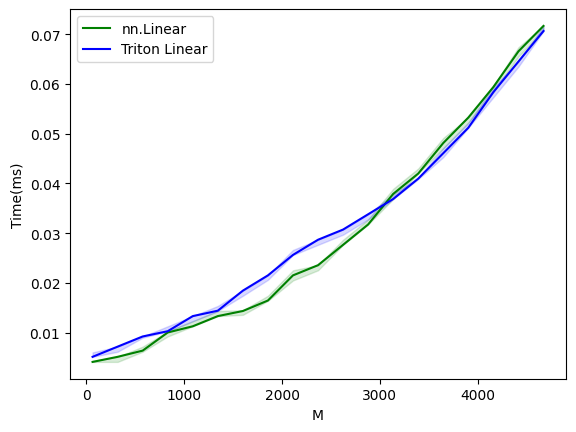

Performance:
         M       N  nn.Linear  Triton Linear
0     64.0    64.0   0.004096       0.005120
1    320.0   320.0   0.005120       0.007168
2    576.0   576.0   0.006368       0.009216
3    832.0   832.0   0.010016       0.010272
4   1088.0  1088.0   0.011264       0.013312
5   1344.0  1344.0   0.013312       0.014400
6   1600.0  1600.0   0.014336       0.018432
7   1856.0  1856.0   0.016448       0.021504
8   2112.0  2112.0   0.021504       0.025616
9   2368.0  2368.0   0.023552       0.028672
10  2624.0  2624.0   0.027648       0.030720
11  2880.0  2880.0   0.031744       0.033792
12  3136.0  3136.0   0.037888       0.036864
13  3392.0  3392.0   0.041984       0.040960
14  3648.0  3648.0   0.048128       0.046080
15  3904.0  3904.0   0.053248       0.051200
16  4160.0  4160.0   0.059392       0.058368
17  4416.0  4416.0   0.066560       0.064512
18  4672.0  4672.0   0.071680       0.070656


In [16]:
import triton
import triton.language as tl
dtype = torch.float16

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N"],
        x_vals=[64 * i for i in range(1, 75, 4)],
        line_arg='provider',
        line_vals=[
            'torch',
            'triton',
        ],
        line_names=[
            "nn.Linear",
            "Triton Linear",
        ],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="Time(ms)",
        plot_name="Performance",
        # values for function arguments not in `x_names` and `y_name`
        args={'batch_size': 1},
    ))
def benchmark(batch_size, M, N, provider, device='cuda:0'):
    torch.set_default_device(device)
    torch.cuda.empty_cache()  # Clear unused GPU memory
    
    quantiles = [0.5, 0.2, 0.8]
    
    A = torch.randn((batch_size, M), device=device, dtype=dtype)
    B = A.view(1, batch_size, M)

    if provider == 'torch':
        linear_torch = nn.Linear(M, N).to(device=device, dtype=dtype)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: linear_torch(A), quantiles=quantiles)
    
    elif provider == 'triton':
        linear_triton = LinearWithBias(M, N).to(device=device, dtype=dtype)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: linear_triton(B), quantiles=quantiles)


    return ms, max_ms, min_ms

benchmark.run(
    show_plots=True,
    print_data=True,
    device='cuda:2',
)


## Triton Linear (int8)

In [10]:
import torch
import torch.nn as nn
import math
import triton
import triton.language as tl
from kernels.quantize_gemm_int8 import quantize_int8, quantize_int8_perrow, matmul_int8

class TritonLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__()
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.in_features = in_features
        self.out_features = out_features
        
        # 初始化权重 (out_features, in_features)
        self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        
        # 预计算量化权重
        self.register_buffer('quantized_weight', None)
        self.register_buffer('weight_scale', None)
        
        self.reset_parameters()
        self.quantize_weight()  # 初始化时预量化权重
    
    def reset_parameters(self):
        # 标准的 PyTorch 初始化方法
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def quantize_weight(self):
        # 转置权重以匹配 matmul 需求：从 (out_features, in_features) 到 (in_features, out_features)
        weight_t = self.weight.t().contiguous()
        # 按列量化（相当于原始权重的行）
        quantized_weight, weight_scale = quantize_int8(weight_t, axis=0)
        self.quantized_weight = quantized_weight
        self.weight_scale = weight_scale
    
    def forward(self, input):
        # 如果处于训练模式或权重尚未量化，则量化权重
        if self.training or self.quantized_weight is None:
            self.quantize_weight()
        
        # 处理输入
        original_shape = input.shape
        if input.dim() > 2:
            # 将高维输入重塑为 2D
            input = input.reshape(-1, input.size(-1))
        
        # 量化输入
        quantized_input, input_scale = quantize_int8_perrow(input)
        
        # 执行量化矩阵乘法
        output = matmul_int8(quantized_input, input_scale, 
                           self.quantized_weight, self.weight_scale)
        
        # 添加偏置（如果存在）
        if self.bias is not None:
            output = output + self.bias
        
        # 恢复原始维度（如果需要）
        if len(original_shape) > 2:
            output_shape = original_shape[:-1] + (self.out_features,)
            output = output.reshape(output_shape)
        
        return output


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M'],  # 批次大小作为 x 轴
        x_vals=[128, 512, 1024, 2048, 8192, 8192 * 2, 8192 * 4, 8192 * 8],  # 不同批次大小
        # x_vals=[2048, 8192, 8192 * 8],  # 不同批次大小
        line_arg='provider',  # 提供者（PyTorch 或 Triton）作为不同线条
        line_vals=['torch', 'triton'],
        line_names=["PyTorch nn.Linear", "Triton Linear"],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",
        plot_name="linear-layer-performance",
        args={'in_features': 4096, 'out_features': 8192},  # 固定输入和输出特征大小
    )
)
def benchmark(M, provider, in_features=4096, out_features=4096, device='cuda:0'):
    # 设置随机种子以确保可重现性
    torch.manual_seed(0)
    quantiles = [0.5, 0.2, 0.8]  # 中位数，20% 和 80% 分位数
    
    torch.set_default_device(device)
    torch.cuda.empty_cache()  # Clear unused GPU memory

    if provider == 'torch':
        # 使用 PyTorch nn.Linear
        module = nn.Linear(in_features, out_features).to(device).half()
        input_data = torch.randn((M, in_features), device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = module(input_data)
        torch.cuda.synchronize()
        
        # 性能测试
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: module(input_data), quantiles=quantiles)
        
    elif provider == 'triton':
        # 使用 Triton Linear
        module = TritonLinear(in_features, out_features).to(device).half()
        input_data = torch.randn((M, in_features), device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = module(input_data)
        torch.cuda.synchronize()
        
        # 性能测试
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: module(input_data), quantiles=quantiles)
    
    # 计算 TFLOPS（乘法-加法操作的数量为 2 * M * in_features * out_features）
    perf = lambda ms: 2 * M * in_features * out_features * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(min_ms), perf(max_ms)

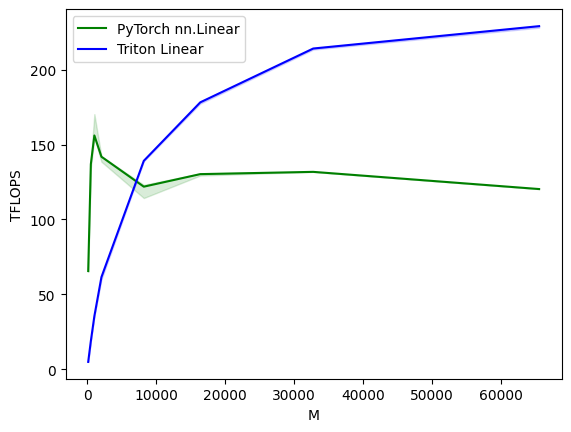

In [11]:
benchmark.run(show_plots=True, device='cuda:2')

## Add

In [17]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.add import *

device = 'cuda'
dtype = torch.float16

A = torch.randn((2, 2000, 5000), dtype=dtype, device=device)
B = torch.randn((2, 2000, 5000), dtype=dtype, device=device)

y_torch = torch.add(A, B)
y_triton = add_triton(A, B)

print(f'Original matrix:\n{A}\n{B}')
print(f'PyTorch patching:\n{y_torch}')
print(f'Triton patching:\n{y_triton}')

if torch.allclose(y_torch, y_triton):
    print('Data matches')

else:
    print('Data does not match')

Original matrix:
tensor([[[-1.9746, -0.1617,  1.4746,  ..., -0.5684,  1.0254,  1.0127],
         [ 2.0684,  0.5620,  0.2400,  ...,  0.8345,  1.4688,  0.2976],
         [-0.1395,  1.2764, -0.5293,  ...,  0.6938, -0.3547,  0.2639],
         ...,
         [ 0.1823, -2.0996, -0.6392,  ...,  0.8135,  2.3828,  0.6885],
         [ 0.1849, -0.3069,  0.3870,  ...,  0.4429, -0.7012, -0.5234],
         [-0.9492,  0.7339,  0.8735,  ..., -0.8452,  1.2549, -0.8975]],

        [[ 0.4990, -0.7573, -0.5684,  ..., -1.0283,  1.8857,  0.3711],
         [-0.7764,  1.3408,  2.0293,  ...,  0.2007,  0.6240,  0.3401],
         [-1.7588, -0.4631,  0.6504,  ..., -0.6660,  0.4431,  0.4546],
         ...,
         [ 0.3560, -0.1353,  1.1191,  ...,  0.2019,  0.0061, -0.6709],
         [-1.5693, -0.4719,  0.7319,  ...,  1.1689,  0.7222,  0.5024],
         [ 0.6782, -0.0212, -0.7886,  ..., -1.3730, -1.8350, -0.5981]]],
       device='cuda:2', dtype=torch.float16)
tensor([[[-1.3896, -0.1793,  0.2258,  ..., -0.6455, -1

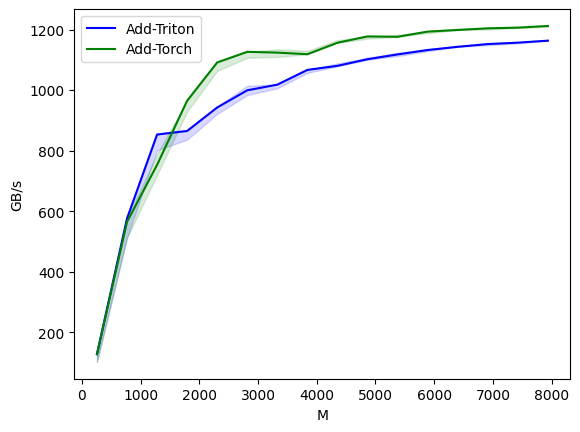

Performance:
         M       N   Add-Triton    Add-Torch
0    256.0   256.0   128.000000   128.000000
1    768.0   768.0   576.000001   564.965499
2   1280.0  1280.0   853.333355   752.941163
3   1792.0  1792.0   865.103427   964.923088
4   2304.0  2304.0   942.545447  1091.368470
5   2816.0  2816.0   999.225820  1126.399991
6   3328.0  3328.0  1017.976475  1123.740304
7   3840.0  3840.0  1066.666665  1118.446618
8   4352.0  4352.0  1080.058430  1156.282235
9   4864.0  4864.0  1101.932789  1177.273869
10  5376.0  5376.0  1117.782202  1175.999958
11  5888.0  5888.0  1132.366856  1193.163012
12  6400.0  6400.0  1142.857112  1198.501892
13  6912.0  6912.0  1152.000024  1204.025794
14  7424.0  7424.0  1156.630939  1206.140016
15  7936.0  7936.0  1163.196244  1211.808163


In [19]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.add import *

device = 'cuda'
dtype = torch.float16
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N'],  # argument names to use as an x-axis for the plot
        # different possible values for `x_name`
        x_vals=[128*i for i in range(2, 64, 4)],
        # argument name whose value corresponds to a different line in the plot
        line_arg='provider',
        line_vals=[
            'triton',
            'torch',
        ],
        line_names=[
            "Add-Triton",
            "Add-Torch",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="Performance",
        args={'B': 1},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(B, M, N, provider, device='cuda:0'):
    torch.set_default_device(device)
    torch.cuda.empty_cache()
    x = torch.randn(B, M, N, device=device, dtype=dtype)
    y = torch.randn(B, M, N, device=device, dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add_triton(x, y), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.add(x, y), quantiles=quantiles)

    def gbps(ms): return B * 2 * (x.nelement() + y.nelement()) * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(
    show_plots=True, # weirdly show_plots and save_paths don't work together
    print_data=True,
    device='cuda:2',
)

## Transpose2D

In [20]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.transpose import *

device = 'cuda:2'
dtype = torch.float16

X = torch.randn((3, 4), dtype=dtype, device=device)

y_torch = torch.transpose(X, 0, 1)
y_triton = triton_transpose(X)

print(f'Original matrix:\n{X}')
print(f'PyTorch:\n{y_torch}')
print(f'Triton:\n{y_triton}')

if torch.allclose(y_torch, y_triton):
    print('Data matches')

else:
    print('Data does not match')

Original matrix:
tensor([[ 0.1548, -0.3132,  1.4385, -1.4551],
        [ 0.3779,  0.8184,  0.7886,  0.2360],
        [ 0.2378, -0.0160, -0.0696,  0.6221]], device='cuda:2',
       dtype=torch.float16)
PyTorch:
tensor([[ 0.1548,  0.3779,  0.2378],
        [-0.3132,  0.8184, -0.0160],
        [ 1.4385,  0.7886, -0.0696],
        [-1.4551,  0.2360,  0.6221]], device='cuda:2', dtype=torch.float16)
Triton:
tensor([[ 0.1548,  0.3779,  0.2378],
        [-0.3132,  0.8184, -0.0160],
        [ 1.4385,  0.7886, -0.0696],
        [-1.4551,  0.2360,  0.6221]], device='cuda:2', dtype=torch.float16)
Data matches


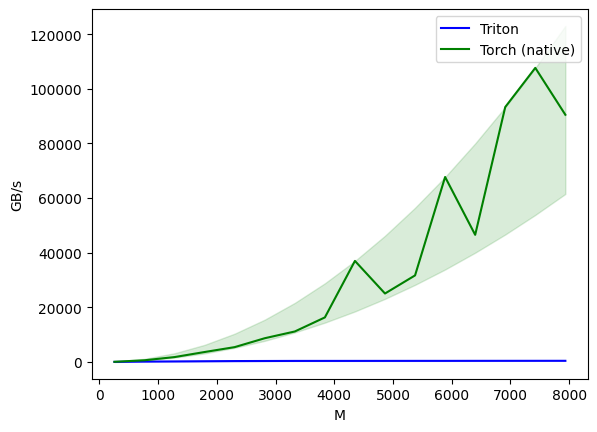

Performance:
         M       N      Triton  Torch (native)
0    256.0   256.0   25.600001       67.147542
1    768.0   768.0  144.000000      624.813540
2   1280.0  1280.0  201.972379     1796.491193
3   1792.0  1792.0  272.695646     3649.163608
4   2304.0  2304.0  334.451617     5438.950925
5   2816.0  2816.0  360.710339     8695.017375
6   3328.0  3328.0  386.285709    11164.903377
7   3840.0  3840.0  389.189172    16311.504154
8   4352.0  4352.0  393.531904    36992.000093
9   4864.0  4864.0  398.344818    25061.965344
10  5376.0  5376.0  403.199989    31690.104648
11  5888.0  5888.0  405.461064    67712.000171
12  6400.0  6400.0  414.507772    46545.454182
13  6912.0  6912.0  420.324320    93312.000236
14  7424.0  7424.0  425.486157   107648.000272
15  7936.0  7936.0  429.933494    90488.643315


In [21]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.transpose import *

dtype = torch.float16
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N'],  # argument names to use as an x-axis for the plot
        # different possible values for `x_name`
        x_vals=[128*i for i in range(2, 64, 4)],
        # argument name whose value corresponds to a different line in the plot
        line_arg='provider',
        line_vals=[
            'triton',
            'torch',
        ],
        line_names=[
            "Triton",
            "Torch (native)",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="Performance",
        args={},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider, device='cuda:0'):
    torch.set_default_device(device)
    torch.cuda.empty_cache()
    x = torch.randn(M, N, device=device, dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_transpose(x), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.transpose(x, 0, 1), quantiles=quantiles)

    def gbps(ms): return x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(
    show_plots=True, # weirdly show_plots and save_paths don't work together
    print_data=True,
    device='cuda:2',
)

## Conv2D

### simple version

In [1]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
import math
from kernels.conv2d import conv2d_triton


class SimpleTritonConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=None, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        super(SimpleTritonConv2d, self).__init__()
        
        # Handle scalar and tuple kernel_size
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        
        # For this implementation, stride must equal kernel_size
        if stride is None:
            stride = kernel_size
        elif isinstance(stride, int):
            stride = (stride, stride)
            
        # Validate that stride equals kernel_size (as required by the kernel)
        if stride != kernel_size:
            raise ValueError(f"This implementation only supports stride == kernel_size. Got stride={stride}, kernel_size={kernel_size}")
        
        # Check other constraints
        if padding != 0 or dilation != 1 or groups != 1:
            raise ValueError("This implementation does not support padding, dilation, or groups. Use padding=0, dilation=1, groups=1.")
        
        self.stride = stride
        self.padding = (0, 0)
        self.dilation = (1, 1)
        self.groups = 1
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Define parameters (weights and bias)
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, *kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        
        # Initialize parameters
        self.reset_parameters()
    
    def reset_parameters(self):
        # Use same initialization as nn.Conv2d
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, input):
        # Call the Triton-based convolution function
        bias = self.bias if self.bias is not None else torch.zeros(self.out_channels, device=input.device, dtype=input.dtype)
        return conv2d_triton(input, self.weight, bias)

In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],  # 变化的是批量大小
        x_vals=[1, 2, 4, 8, 16, 32, 64],
        line_arg='provider',
        line_vals=[
            'torch',
            'triton',
        ],
        line_names=[
            "nn.Conv2d",
            "Triton Conv2d",
        ],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="Time(ms)",
        plot_name="卷积性能对比 (批量大小)",
        # 其他固定参数
        args={'C': 64, 'H': 64, 'W': 64, 'K': 128, 'kernel_size': 4},  # 使用kernel_size=4
    ))
def benchmark_conv2d_batchsize(N, C, H, W, K, kernel_size, provider, device='cuda:0'):
    """
    对比PyTorch的nn.Conv2d与Triton实现的卷积性能
    
    注意: Triton实现的卷积有以下限制:
    1. stride必须等于kernel_size
    2. 输入尺寸(H,W)必须能被kernel_size整除
    3. 不支持padding和dilation
    """
    torch.set_default_device(device)
    torch.cuda.empty_cache()
    
    quantiles = [0.5, 0.2, 0.8]
    
    # 创建随机输入张量
    x = torch.randn((N, C, H, W), device=device, dtype=torch.float16)
    
    # 卷积参数 - 确保stride等于kernel_size
    stride = kernel_size
    padding = 0  # 不使用padding，因为Triton实现不支持
    
    if provider == 'torch':
        # PyTorch实现
        conv_torch = nn.Conv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = conv_torch(x)
        torch.cuda.synchronize()
        
        # 基准测试
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_torch(x), quantiles=quantiles
        )
    
    elif provider == 'triton':
        # Triton实现
        conv_triton = SimpleTritonConv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = conv_triton(x)
        torch.cuda.synchronize()
        
        # 基准测试
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_triton(x), quantiles=quantiles
        )

    return ms, max_ms, min_ms


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],  # 变化的是特征图尺寸
        x_vals=[16, 32, 64, 128, 256],
        line_arg='provider',
        line_vals=['torch', 'triton'],
        line_names=["nn.Conv2d", "Triton Conv2d"],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="Time(ms)",
        plot_name="卷积性能对比 (特征图尺寸)",
        args={'N': 8, 'C': 64, 'K': 128, 'kernel_size': 4},  # 使用kernel_size=4
    ))
def benchmark_spatial_scaling(size, N, C, K, kernel_size, provider, device='cuda:0'):
    """
    测试卷积性能随特征图尺寸的变化
    
    注意: Triton实现的卷积有以下限制:
    1. stride必须等于kernel_size
    2. 输入尺寸(H,W)必须能被kernel_size整除
    3. 不支持padding和dilation
    """
    torch.set_default_device(device)
    torch.cuda.empty_cache()
    
    H, W = size, size  # 正方形输入
    quantiles = [0.5, 0.2, 0.8]
    
    x = torch.randn((N, C, H, W), device=device, dtype=torch.float16)
    stride = kernel_size  # 确保stride等于kernel_size
    padding = 0  # 不使用padding
    
    if provider == 'torch':
        conv_torch = nn.Conv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = conv_torch(x)
        torch.cuda.synchronize()
        
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_torch(x), quantiles=quantiles
        )
    
    elif provider == 'triton':
        conv_triton = SimpleTritonConv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 预热
        for _ in range(10):
            _ = conv_triton(x)
        torch.cuda.synchronize()
        
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_triton(x), quantiles=quantiles
        )

    return ms, max_ms, min_ms

运行批量大小基准测试...


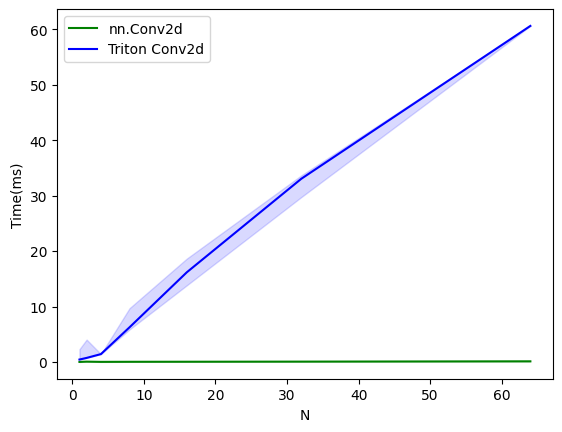

卷积性能对比 (批量大小):
      N  nn.Conv2d  Triton Conv2d
0   1.0   0.020528       0.451584
1   2.0   0.069632       0.742912
2   4.0   0.029792       1.431552
3   8.0   0.043008       6.264832
4  16.0   0.052224      16.180016
5  32.0   0.073728      33.041409
6  64.0   0.129024      60.593151
运行特征图尺寸基准测试...


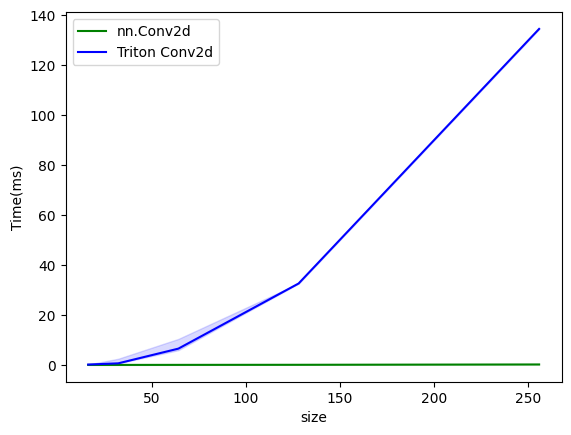

卷积性能对比 (特征图尺寸):
    size  nn.Conv2d  Triton Conv2d
0   16.0   0.023552       0.172032
1   32.0   0.026624       0.658432
2   64.0   0.043968       6.539776
3  128.0   0.073728      32.610817
4  256.0   0.207776     134.465530


In [5]:
if __name__ == "__main__":
    # 运行批量大小基准测试
    print("运行批量大小基准测试...")
    benchmark_conv2d_batchsize.run(
        show_plots=True,
        print_data=True,
        device='cuda:0',  # 指定设备
    )
    
    # 运行特征图尺寸基准测试
    print("运行特征图尺寸基准测试...")
    benchmark_spatial_scaling.run(
        show_plots=True,
        print_data=True,
        device='cuda:0',  # 指定设备
    )

### implicit GEMM

运行批量大小基准测试...


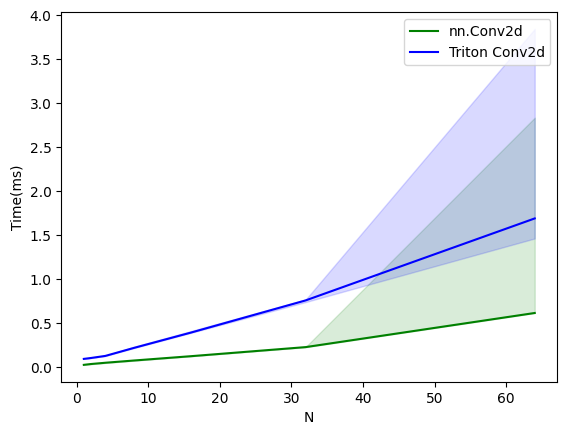

卷积性能对比 (批量大小):
      N  nn.Conv2d  Triton Conv2d
0   1.0   0.023360       0.091136
1   2.0   0.032768       0.101376
2   4.0   0.047104       0.124928
3   8.0   0.072704       0.216064
4  16.0   0.122080       0.391168
5  32.0   0.225280       0.756736
6  64.0   0.613376       1.689088
运行特征图尺寸基准测试...


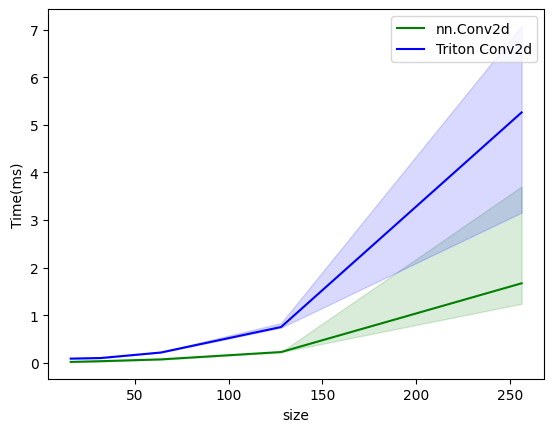

卷积性能对比 (特征图尺寸):
    size  nn.Conv2d  Triton Conv2d
0   16.0   0.019456       0.089088
1   32.0   0.034816       0.101376
2   64.0   0.072704       0.217088
3  128.0   0.227328       0.753664
4  256.0   1.671680       5.262336


In [1]:
import torch
import triton
import torch.nn as nn
import matplotlib.pyplot as plt

from kernels.conv2d_implicit_gemm import *

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],  # 变化的是批量大小
        x_vals=[1, 2, 4, 8, 16, 32, 64],
        line_arg='provider',
        line_vals=[
            'torch',
            'triton',
        ],
        line_names=[
            "nn.Conv2d",
            "Triton Conv2d",
        ],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="Time(ms)",
        plot_name="卷积性能对比 (批量大小)",
        # 其他固定参数
        args={'C': 64, 'H': 64, 'W': 64, 'K': 128, 'kernel_size': 3},
    ))
def benchmark_conv2d_batchsize(N, C, H, W, K, kernel_size, provider, device='cuda:0'):
    """
    对比PyTorch的nn.Conv2d与Triton实现的卷积性能
    
    参数:
    -----
    N: int
        批量大小
    C: int
        输入通道数
    H, W: int
        输入特征图尺寸
    K: int
        输出通道数
    kernel_size: int
        卷积核大小(方形)
    provider: str
        'torch'或'triton'
    device: str
        运行设备
    """
    torch.set_default_device(device)
    torch.cuda.empty_cache()  # 清理未使用的GPU内存
    
    quantiles = [0.5, 0.2, 0.8]
    
    # 创建随机输入张量
    x = torch.randn((N, C, H, W), device=device, dtype=torch.float16)
    
    # 卷积参数
    stride = (1, 1)
    padding = (kernel_size // 2, kernel_size // 2)  # same padding
    dilation = (1, 1)
    
    if provider == 'torch':
        # PyTorch实现
        conv_torch = nn.Conv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, dilation=dilation, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 基准测试
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_torch(x), quantiles=quantiles
        )
    
    elif provider == 'triton':
        # Triton实现
        conv_triton = Conv2d_triton(
            C, K, kernel_size,
            stride=stride, padding=padding, dilation=dilation, bias=True
        ).to(device=device, dtype=torch.float16)
        
        # 基准测试
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_triton(x), quantiles=quantiles
        )

    return ms, max_ms, min_ms


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],  # 变化的是特征图尺寸
        x_vals=[16, 32, 64, 128, 256],
        line_arg='provider',
        line_vals=['torch', 'triton'],
        line_names=["nn.Conv2d", "Triton Conv2d"],
        styles=[('green', '-'), ('blue', '-')],
        ylabel="Time(ms)",
        plot_name="卷积性能对比 (特征图尺寸)",
        args={'N': 8, 'C': 64, 'K': 128, 'kernel_size': 3},
    ))
def benchmark_spatial_scaling(size, N, C, K, kernel_size, provider, device='cuda:0'):
    """测试卷积性能随特征图尺寸的变化"""
    torch.set_default_device(device)
    torch.cuda.empty_cache()
    
    H, W = size, size  # 正方形输入
    quantiles = [0.5, 0.2, 0.8]
    
    x = torch.randn((N, C, H, W), device=device, dtype=torch.float16)
    stride = (1, 1)
    padding = (kernel_size // 2, kernel_size // 2)
    dilation = (1, 1)
    
    if provider == 'torch':
        conv_torch = nn.Conv2d(
            C, K, kernel_size,
            stride=stride, padding=padding, dilation=dilation, bias=True
        ).to(device=device, dtype=torch.float16)
        
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_torch(x), quantiles=quantiles
        )
    
    elif provider == 'triton':
        conv_triton = Conv2d_triton(
            C, K, kernel_size,
            stride=stride, padding=padding, dilation=dilation, bias=True
        ).to(device=device, dtype=torch.float16)
        
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv_triton(x), quantiles=quantiles
        )

    return ms, max_ms, min_ms


if __name__ == "__main__":
    # 运行批量大小基准测试
    print("运行批量大小基准测试...")
    benchmark_conv2d_batchsize.run(
        show_plots=True,
        print_data=True,
        device='cuda:0',  # 指定设备
    )
    
    # 运行特征图尺寸基准测试
    print("运行特征图尺寸基准测试...")
    benchmark_spatial_scaling.run(
        show_plots=True,
        print_data=True,
        device='cuda:0',  # 指定设备
    )

## FlashAttention